## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from typing import Tuple
import sys
from pathlib import Path
from datetime import datetime
import os
import pyro

# Add parent directory to path to import Models
# This works for notebooks in the Experiments folder
project_root = Path.cwd().parent if Path.cwd().name == 'Experiments' else Path.cwd()
sys.path.insert(0, str(project_root))

# Setup results directory
results_dir = project_root / "results" / "sample_size"
results_dir.mkdir(parents=True, exist_ok=True)
plots_dir = results_dir / "plots"
plots_dir.mkdir(exist_ok=True)
stats_dir = results_dir / "statistics"
stats_dir.mkdir(exist_ok=True)

print(f"Results will be saved to: {results_dir}")

# Import from Models folder
from Models.MC_Dropout import (
    MCDropoutRegressor,
    train_model,
    mc_dropout_predict,
    gaussian_nll,
    beta_nll,
    plot_toy_data,
    plot_uncertainties,
    normalize_x,
    normalize_x_data
)

from Models.Deep_Ensemble import (
    train_ensemble_deep,
    ensemble_predict_deep
)

from Models.BNN import (
    train_bnn,
    bnn_predict,
    normalize_x as bnn_normalize_x,
    normalize_x_data as bnn_normalize_x_data
)

from Models.BAMLSS import (
    fit_bamlss,
    bamlss_predict
)

from utils.device import get_device
from utils.plotting import plot_toy_data, plot_uncertainties_no_ood
import utils.results_save as results_save_module
from utils.results_save import save_plot, save_statistics, save_summary_text, save_summary_statistics

# Import helper functions for sample size experiments
from utils.sample_size_experiments import (
    run_mc_dropout_sample_size_experiment,
    run_deep_ensemble_sample_size_experiment,
    run_bnn_sample_size_experiment,
    run_bamlss_sample_size_experiment
)

# Set the module-level directories for results_save
results_save_module.plots_dir = plots_dir
results_save_module.stats_dir = stats_dir


Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


Results will be saved to: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size
CUDA not available. Using CPU.
CUDA not available. Using CPU.


## Device Setup


In [2]:
device = get_device()


CUDA not available. Using CPU.


## Generate Toy Datasets


In [3]:
# Reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ----- Data generation for linear function with homo/heteroscedastic noise -----
# f(x) = 0.7x + 0.5
# noise_type: 'homoscedastic' (σ(x) = 0.20) or 'heteroscedastic' (σ(x) = 0.10 + 0.2(0.5 + 0.5sin(x)))
def generate_toy_regression(n_train=1000, train_range=(0.0, 10.0), 
                           grid_points=1000, noise_type='heteroscedastic', type = "linear"):
    low, high = train_range
    x_train = np.random.uniform(low, high, size=(n_train, 1))
    
    if type == "linear":
        # Linear function: f(x) = 0.7x + 0.5
        f_clean = lambda x: 0.7 * x + 0.5
        y_clean_train = f_clean(x_train)
    elif type == "sin":
        f_clean = lambda x:  x * np.sin(x) + x
        y_clean_train = f_clean(x_train)
    else:
        raise ValueError("type must be 'linear', 'sin'")

    # Define noise variance σ²(x)
    if noise_type == 'homoscedastic':
        # Homoscedastic: σ(x) = 0.8
        sigma = 2
        sigma_train = np.full_like(x_train, sigma)
    elif noise_type == 'heteroscedastic':
        # Heteroscedastic: 
        sigma_train = np.abs(2.5 * np.sin(0.5*x_train +5))
    else:
        raise ValueError("noise_type must be 'homoscedastic' or 'heteroscedastic'")
    
    # Generate noise: ε | x ~ N(0, σ²(x))
    epsilon = np.random.normal(0.0, sigma_train, size=(n_train, 1))
    y_train = y_clean_train + epsilon

    # Dense evaluation grid within training range
    x_grid = np.linspace(train_range[0], train_range[1], grid_points).reshape(-1, 1)
    y_grid_clean = f_clean(x_grid)

    return (x_train.astype(np.float32), y_train.astype(np.float32),
            x_grid.astype(np.float32), y_grid_clean.astype(np.float32))


In [ ]:
# Polynomial function with homoscedastic noise
x_train_homo, y_train_homo, x_grid_homo, y_clean_homo = generate_toy_regression(
    n_train=1000, 
    train_range=(-5,10), 
    noise_type='homoscedastic',
    type = "sin"
)

# Polynomial function with heteroscedastic noise (default - used in most experiments)
x_train, y_train, x_grid, y_clean = generate_toy_regression(
    n_train = 1000, 
    train_range=(-5,10), 
    noise_type='heteroscedastic',
    type = "sin"
)

In [ ]:
plot_toy_data(x_train_homo, y_train_homo, x_grid_homo, y_clean_homo, title="Toy Regression Data Homescedastic (n=1000)")

In [ ]:
plot_toy_data(x_train, y_train, x_grid, y_clean, title="Toy Regression Data Heteroscedastic (n=1000)")

### Set parameters

In [4]:
percentages=[5]
n_train_full = 1000
train_range = (-5,10)
grid_points = 1000
seed = 42
torch.manual_seed(seed)




## MC Dropout - Homoscedastic



################################################################################
# Function Type: Linear (linear) - MC Dropout
################################################################################


Training with 5% of training data (50 samples)
CUDA not available. Using CPU.
[beta_nll] Epoch 100/700 - avg loss 3.1636
[beta_nll] Epoch 200/700 - avg loss 3.3266
[beta_nll] Epoch 300/700 - avg loss 3.1676
[beta_nll] Epoch 400/700 - avg loss 2.9634
[beta_nll] Epoch 500/700 - avg loss 3.1797
[beta_nll] Epoch 600/700 - avg loss 3.0360
[beta_nll] Epoch 700/700 - avg loss 2.8050
CUDA not available. Using CPU.
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\uncertainties\homoscedastic\linear\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_5%_training_data_-_Variance.png


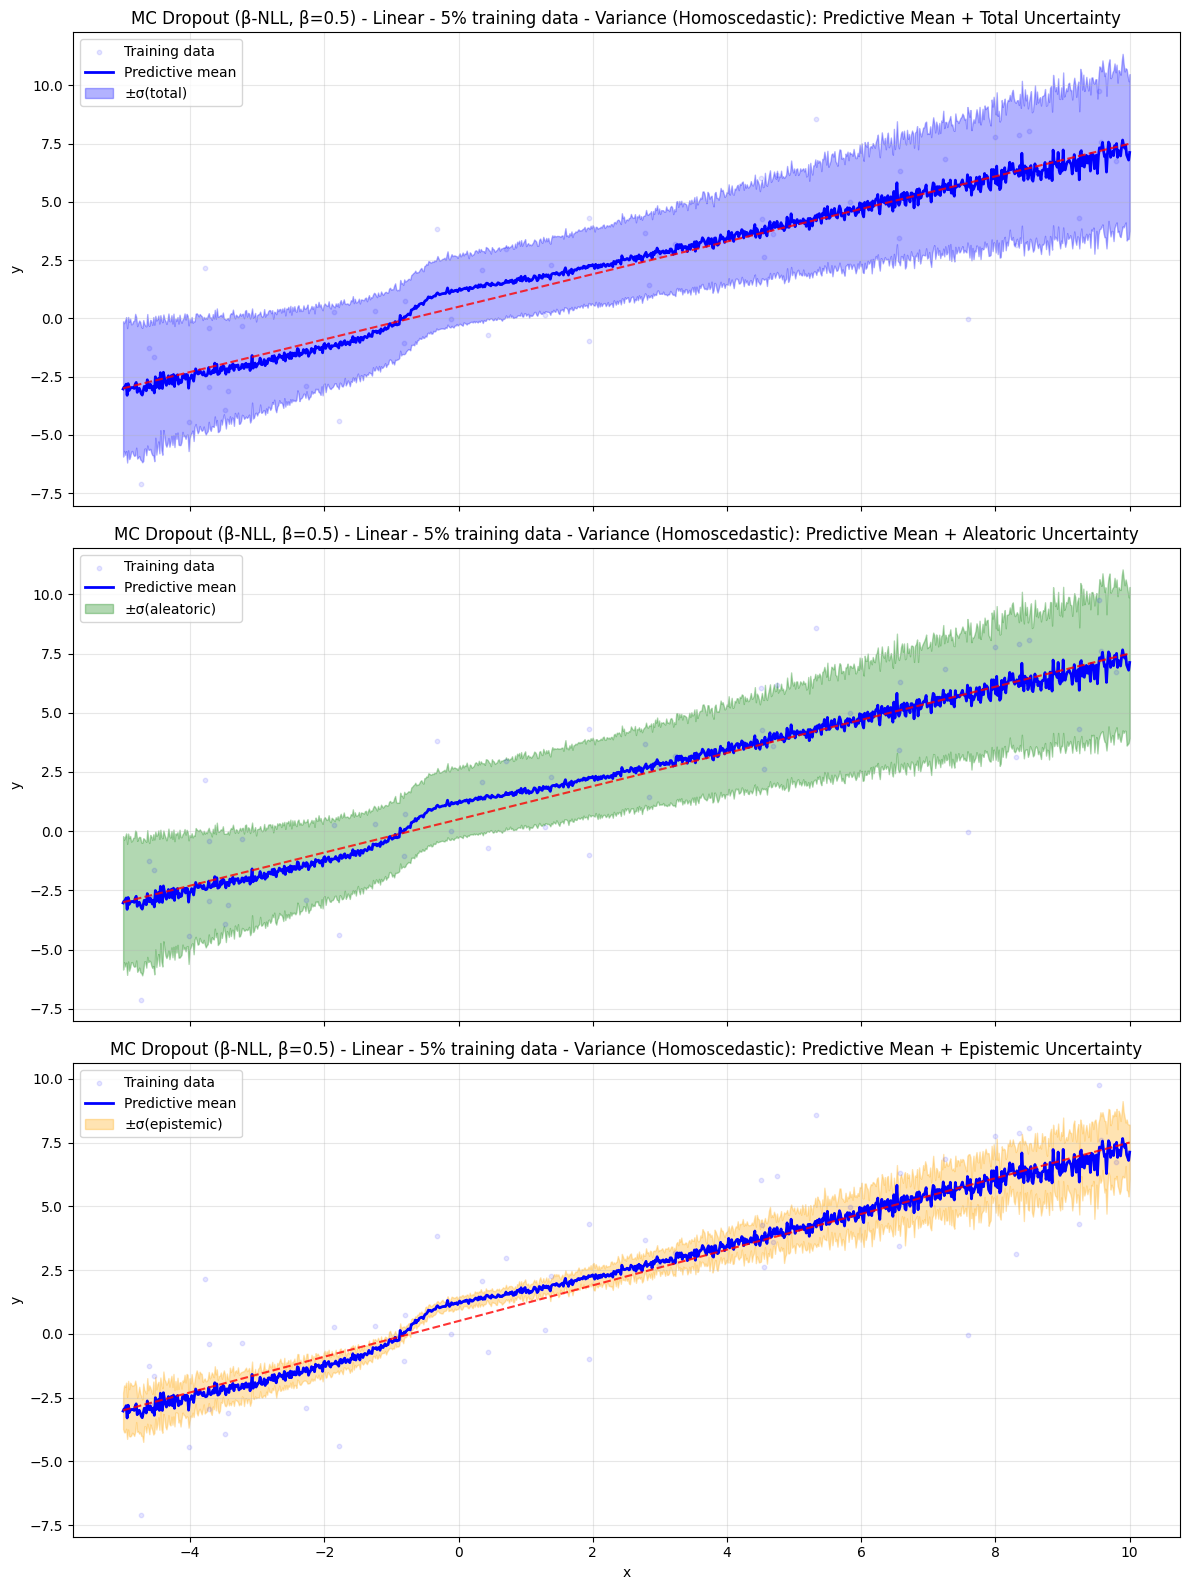

Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\uncertainties_entropy\homoscedastic\linear\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_5%_training_data_-_Entropy_entropy.png


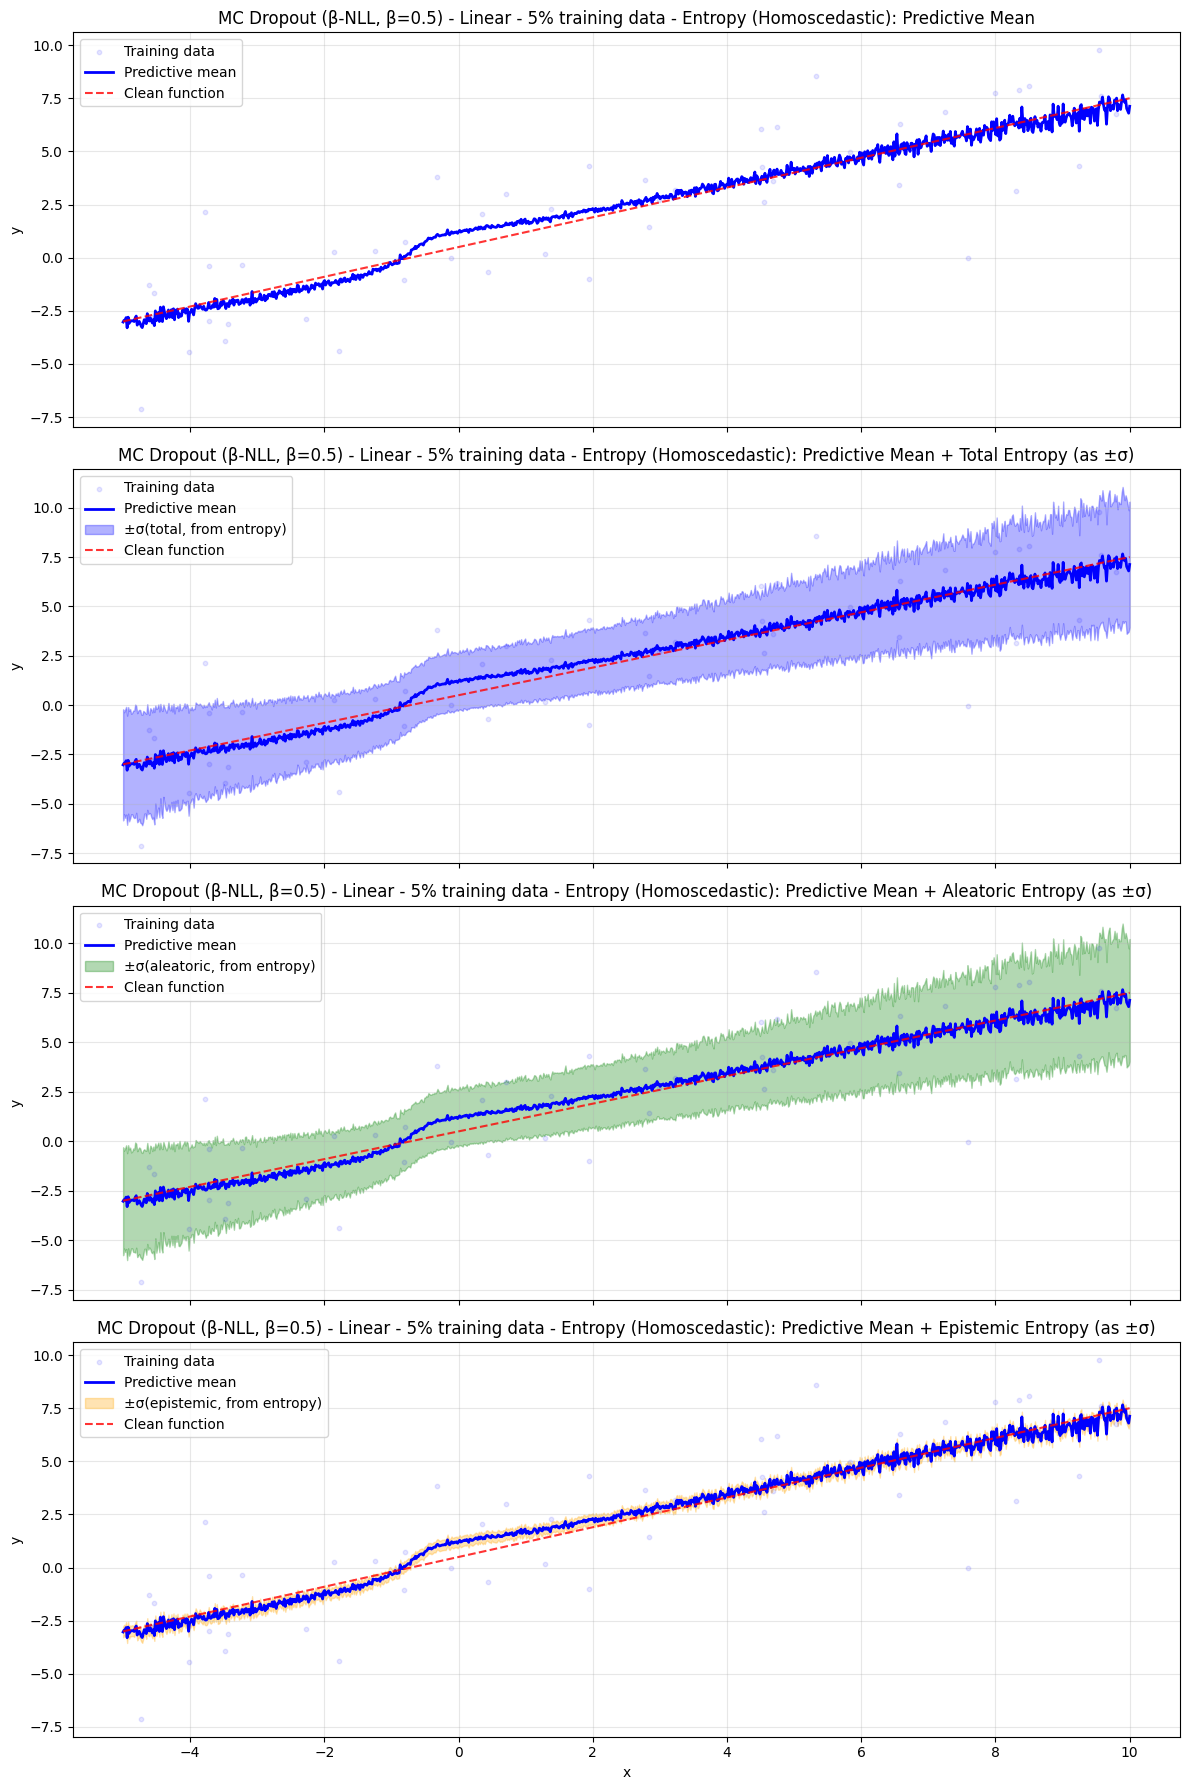


Normalized Average Uncertainties by Percentage - Linear Function - MC_Dropout

Percentage   Avg Aleatoric (norm)      Avg Epistemic (norm)      Avg Total (norm)          Correlation (Epi-Ale)     MSE            
--------------------------------------------------------------------------------------------------------------------------------------------
  5%                        0.294825                  0.139491                  0.434317                  0.868017         0.119252

Note: Average values are normalized to [0, 1] range across all percentages
      Correlation is computed on original (non-normalized) uncertainty values
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\statistics\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_uncertainties_summary_Linear_homoscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-ev

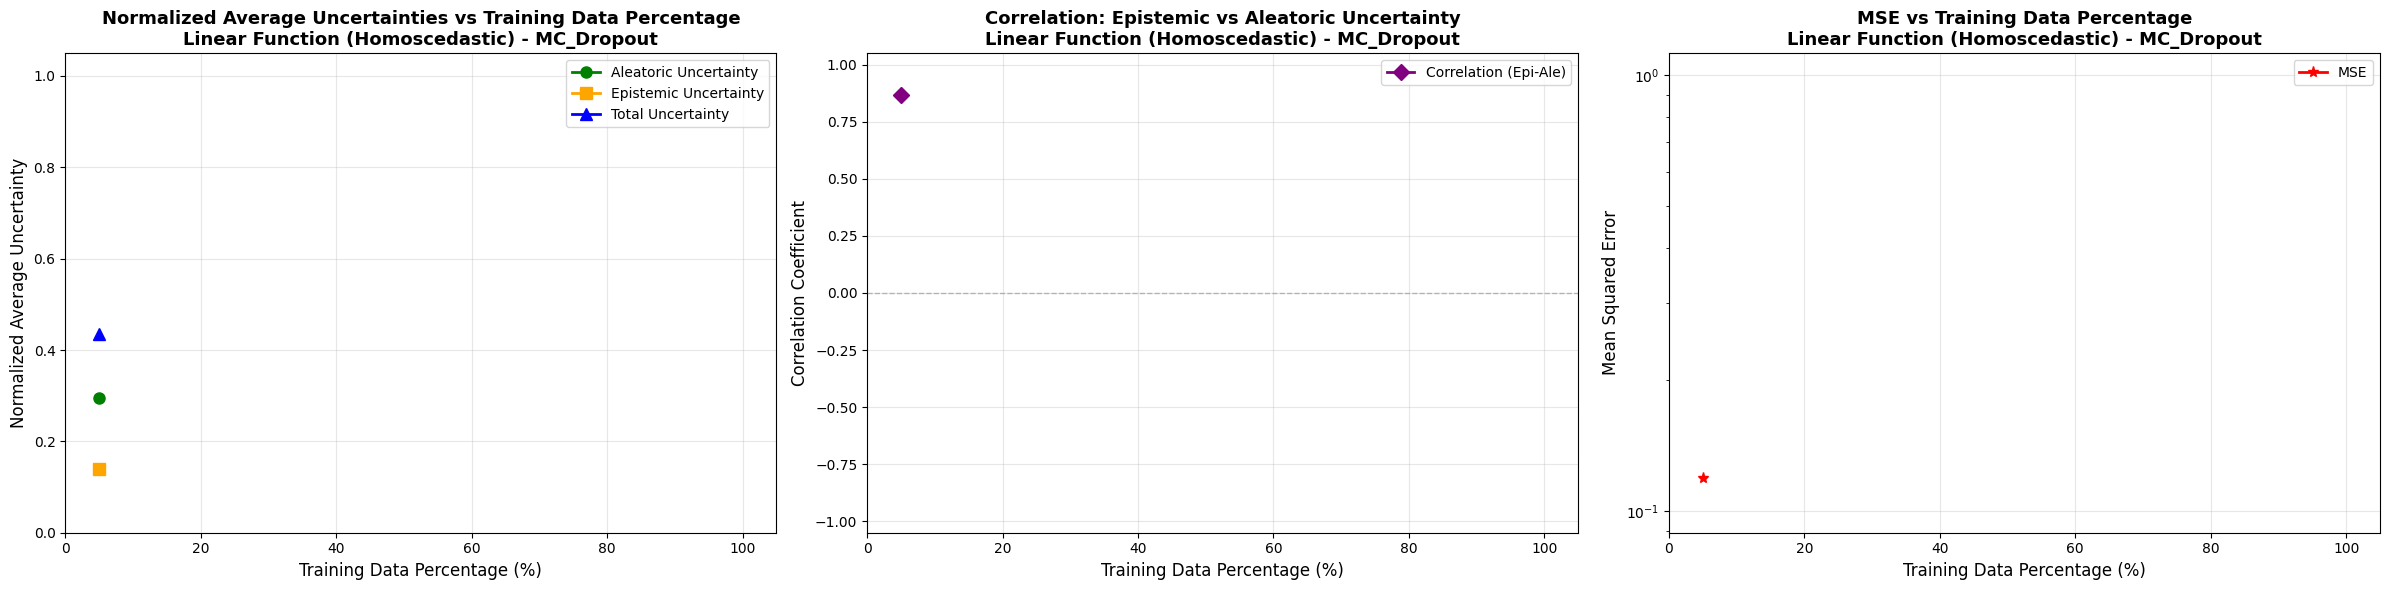


Average Entropies by Percentage - Linear Function - MC_Dropout

Percentage   Avg Aleatoric (nats)      Avg Epistemic (nats)      Avg Total (nats)          Correlation (Epi-Ale)     MSE            
--------------------------------------------------------------------------------------------------------------------------------------------
5                            2.111535                  0.023536                  2.135071                  0.487027         0.119252

Note: Entropy values are in nats (natural logarithm base)
      Correlation is computed on entropy values
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\statistics\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_uncertainties_summary_Linear_homoscedastic_entropy.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\res

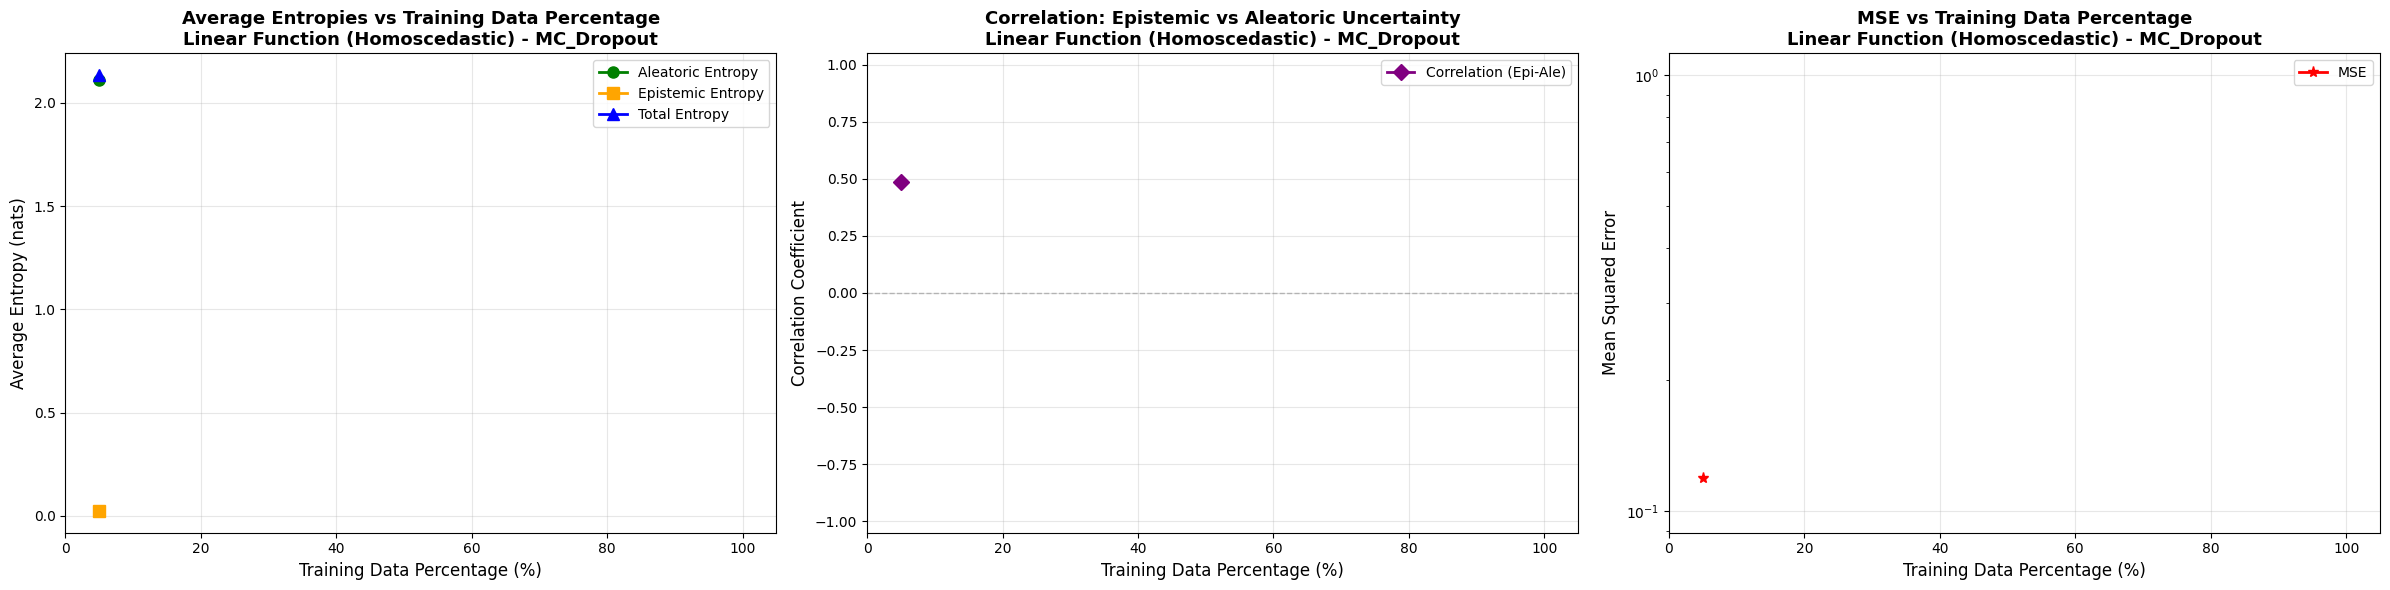


################################################################################
# Function Type: Sinusoidal (sin) - MC Dropout
################################################################################


Training with 5% of training data (50 samples)
CUDA not available. Using CPU.
[beta_nll] Epoch 100/700 - avg loss 7.8244
[beta_nll] Epoch 200/700 - avg loss 6.4740
[beta_nll] Epoch 300/700 - avg loss 6.3904
[beta_nll] Epoch 400/700 - avg loss 6.3607
[beta_nll] Epoch 500/700 - avg loss 6.4908
[beta_nll] Epoch 600/700 - avg loss 5.9862
[beta_nll] Epoch 700/700 - avg loss 5.9389
CUDA not available. Using CPU.
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\uncertainties\homoscedastic\sin\MC_Dropout_(β-NLL,_β=0.5)_-_Sinusoidal_-_5%_training_data_-_Variance.png


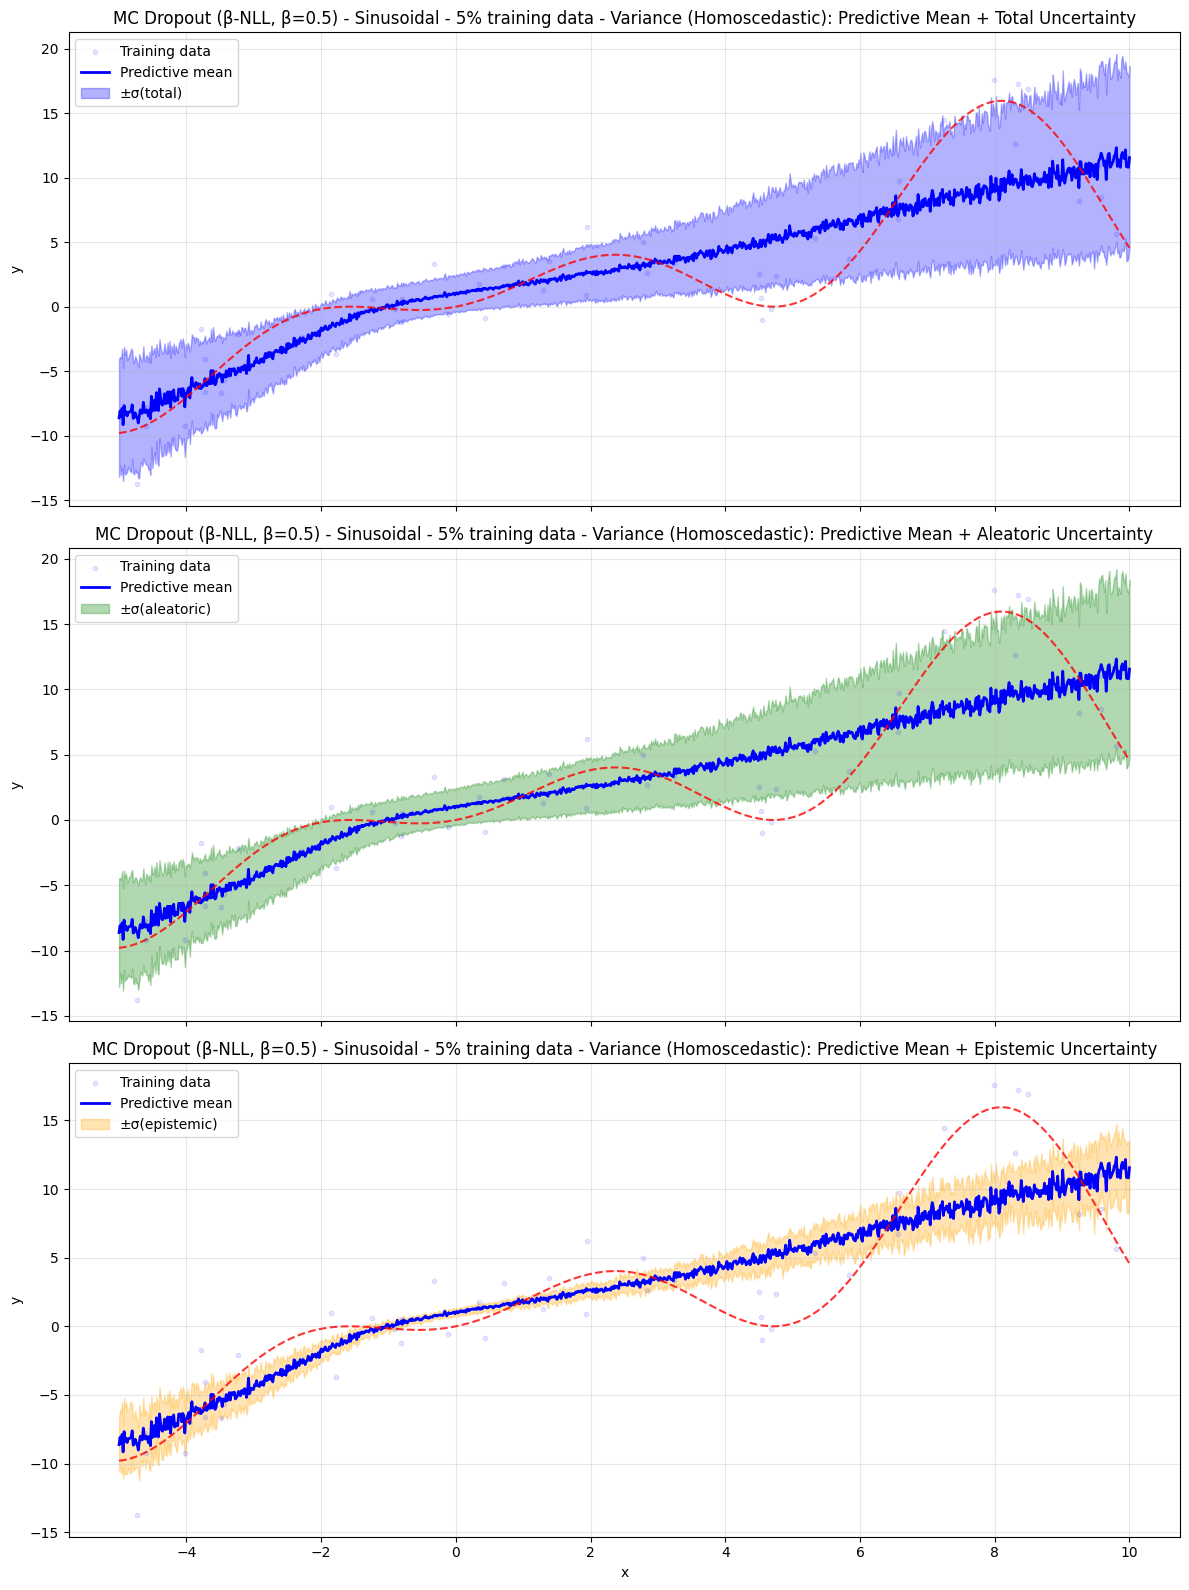

Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\uncertainties_entropy\homoscedastic\sin\MC_Dropout_(β-NLL,_β=0.5)_-_Sinusoidal_-_5%_training_data_-_Entropy_entropy.png


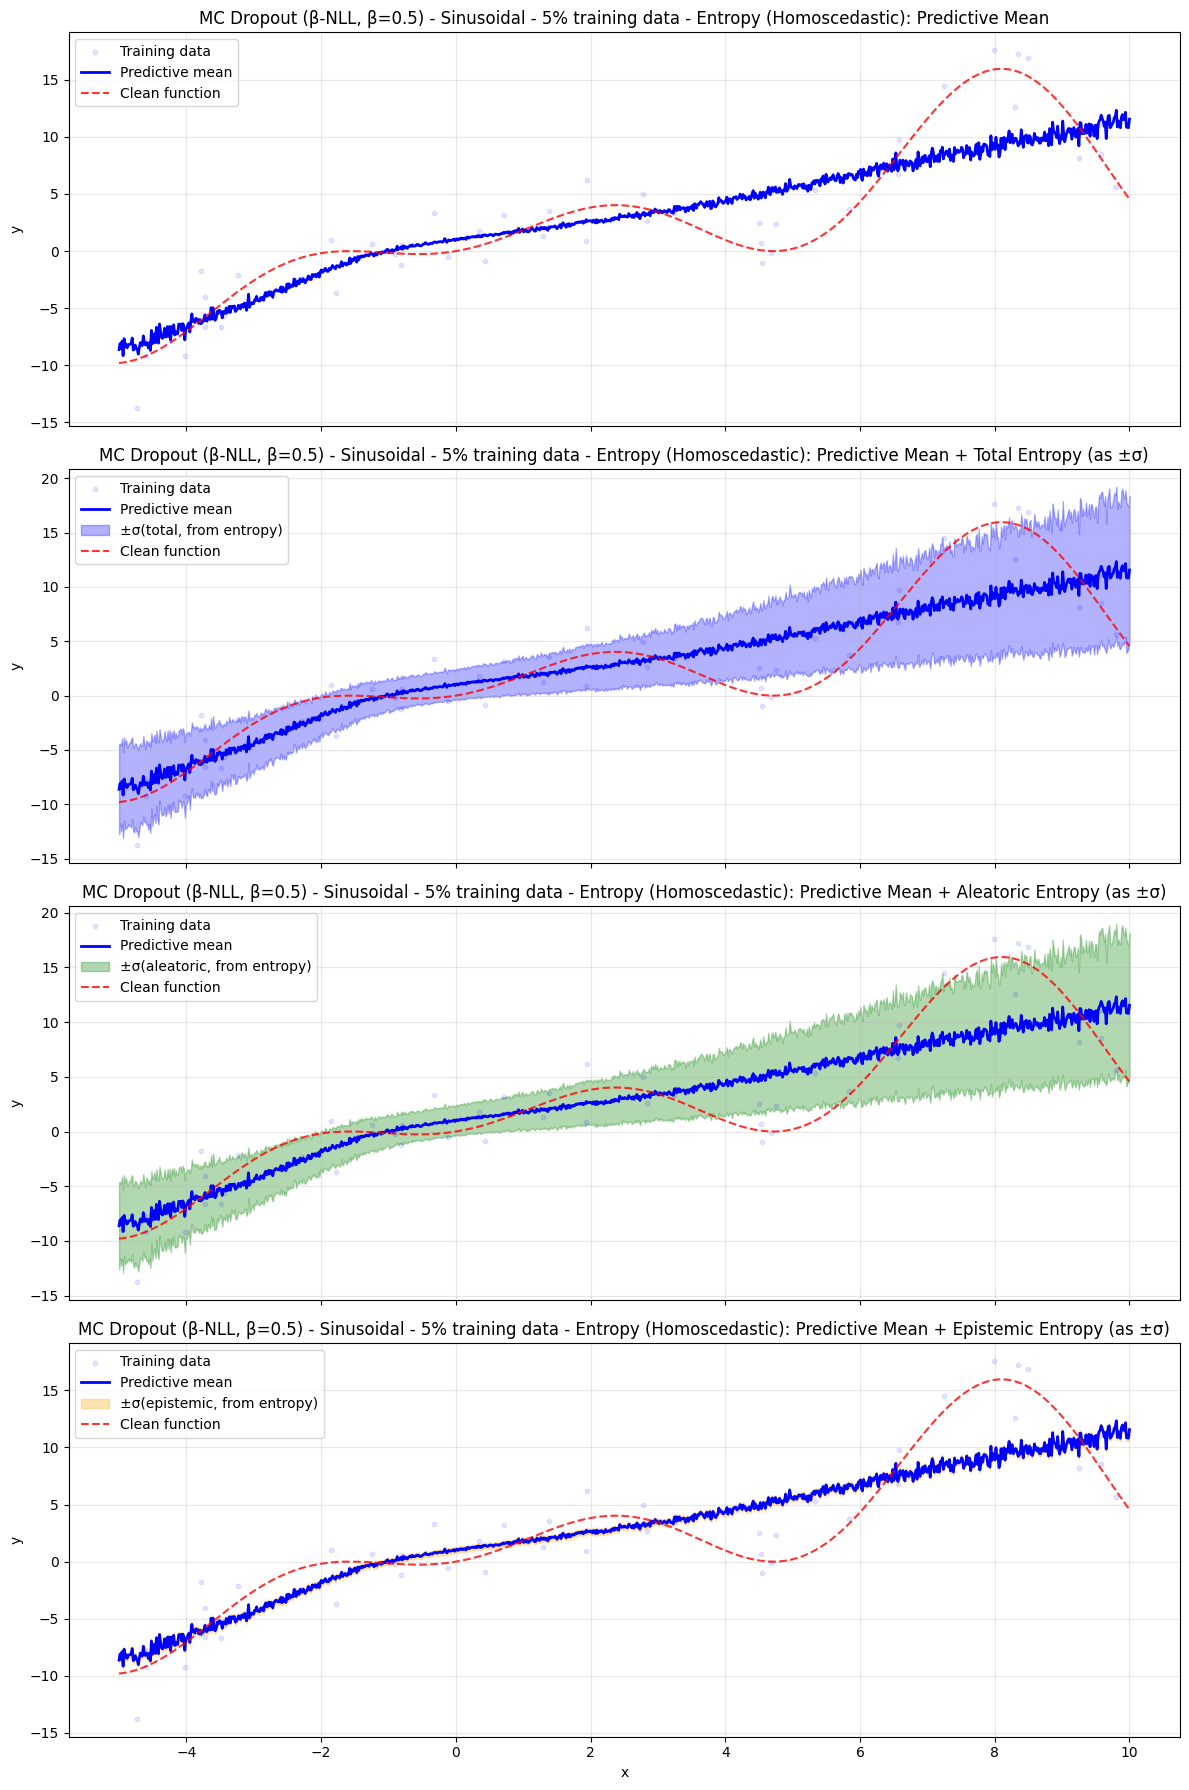


Normalized Average Uncertainties by Percentage - Sinusoidal Function - MC_Dropout

Percentage   Avg Aleatoric (norm)      Avg Epistemic (norm)      Avg Total (norm)          Correlation (Epi-Ale)     MSE            
--------------------------------------------------------------------------------------------------------------------------------------------
  5%                        0.235689                  0.145481                  0.381169                  0.822923         8.947958

Note: Average values are normalized to [0, 1] range across all percentages
      Correlation is computed on original (non-normalized) uncertainty values
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\statistics\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_uncertainties_summary_Sinusoidal_homoscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistic

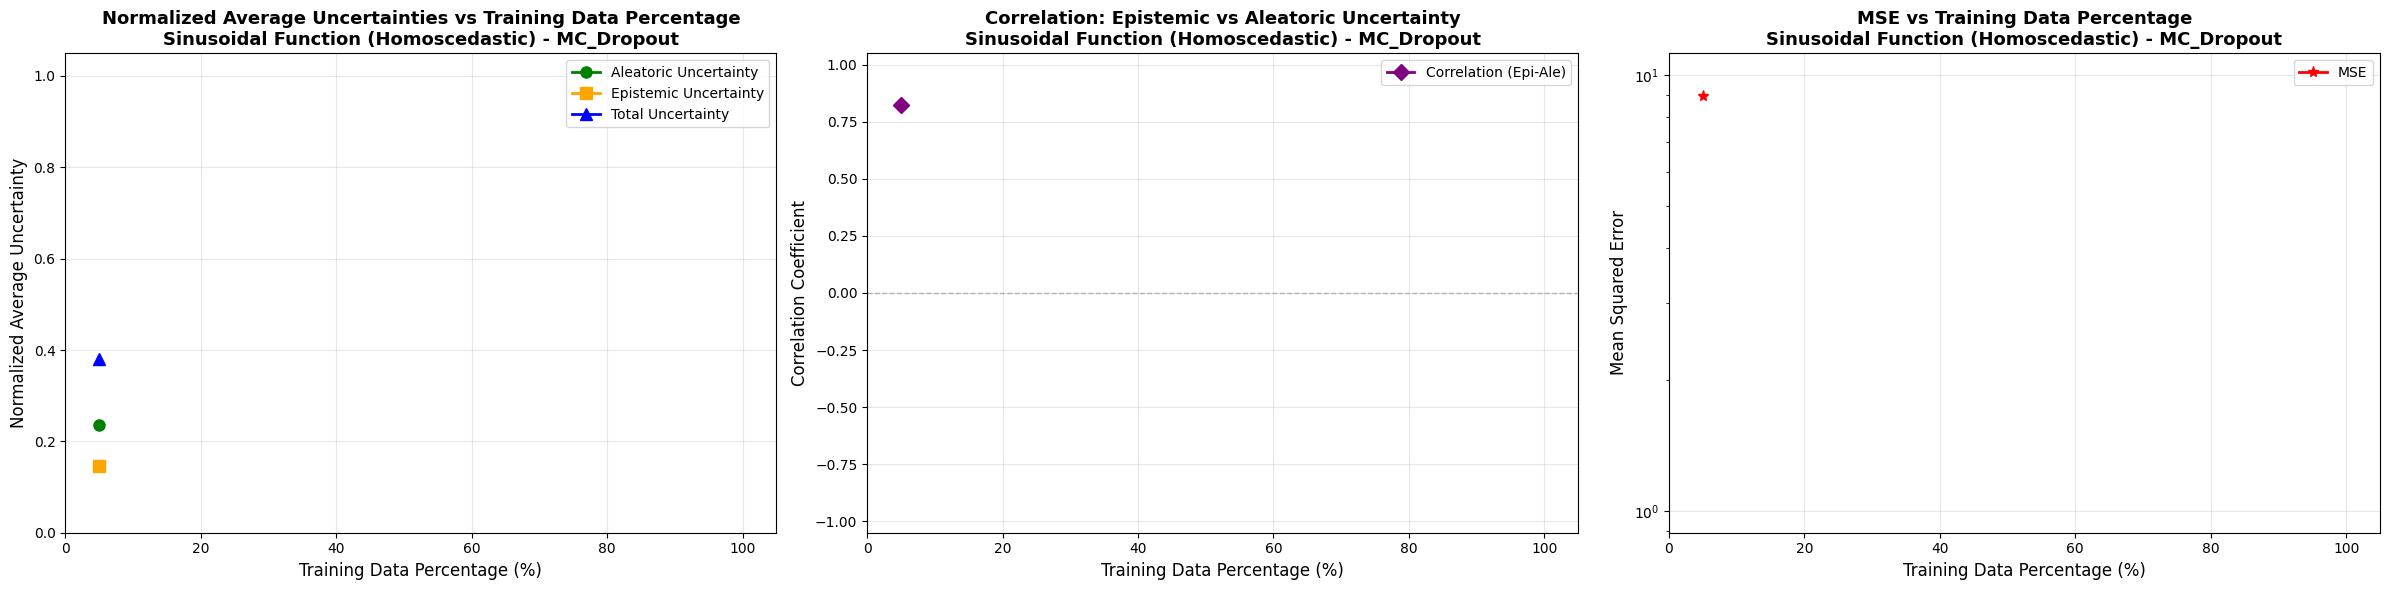


Average Entropies by Percentage - Sinusoidal Function - MC_Dropout

Percentage   Avg Aleatoric (nats)      Avg Epistemic (nats)      Avg Total (nats)          Correlation (Epi-Ale)     MSE            
--------------------------------------------------------------------------------------------------------------------------------------------
5                            2.464732                  0.029157                  2.493890                  0.462119         8.947958

Note: Entropy values are in nats (natural logarithm base)
      Correlation is computed on entropy values
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\statistics\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_uncertainties_summary_Sinusoidal_homoscedastic_entropy.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-

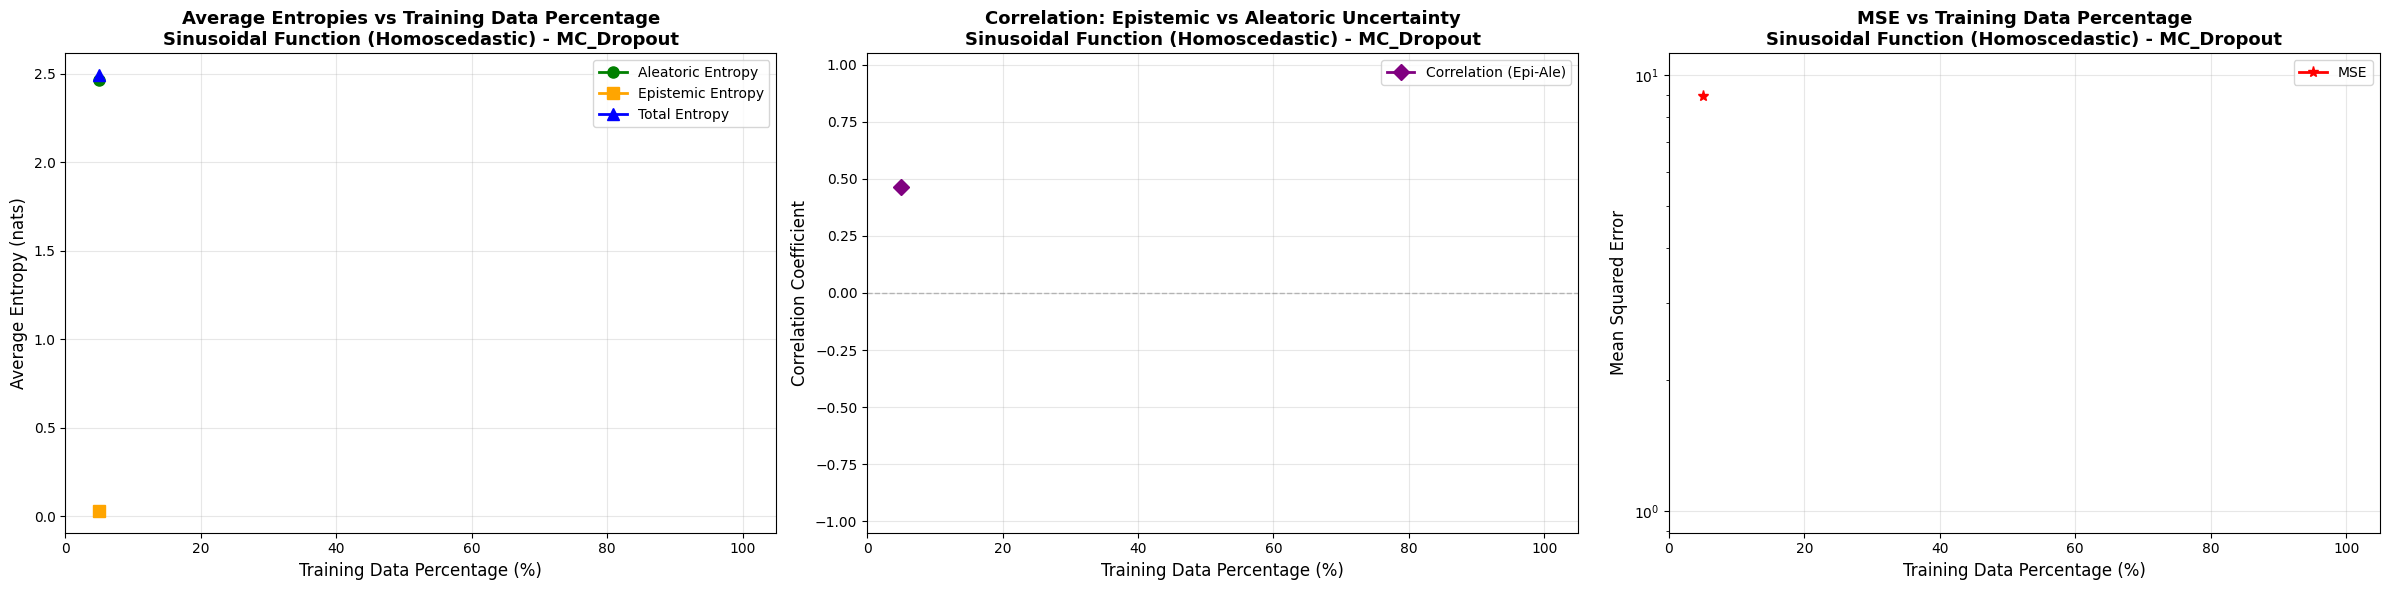

In [5]:
run_mc_dropout_sample_size_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='homoscedastic',
    percentages=percentages,
    n_train_full = n_train_full,
    train_range=train_range,
    grid_points=grid_points,
    seed=seed,
    p=0.2,
    beta=0.5,
    epochs=700,
    lr=1e-3,
    batch_size=32,
    mc_samples=20
)


## MC Dropout - Heteroscedastic


In [ ]:
run_mc_dropout_sample_size_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='heteroscedastic',
    percentages=percentages,
    n_train_full = n_train_full,
    train_range=train_range,
    grid_points=600,
    seed=seed,
    p=0.2,
    beta=0.5,
    epochs=700,
    lr=1e-3,
    batch_size=32,
    mc_samples=20
)


## Deep Ensemble - Homoscedastic


In [ ]:
run_deep_ensemble_sample_size_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='homoscedastic',
    percentages=percentages,
    n_train_full = n_train_full,
    train_range=train_range,
    grid_points=grid_points,
    seed=seed,
    beta=0.5,
    batch_size=32,
    K=5
)


## Deep Ensemble - Heteroscedastic


In [ ]:
run_deep_ensemble_sample_size_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='heteroscedastic',
    percentages=percentages,
    n_train_full = n_train_full,
    train_range=train_range,
    grid_points=grid_points,
    seed=seed,
    beta=0.5,
    batch_size=32,
    K=5
)


## BNN - Homoscedastic


In [ ]:
run_bnn_sample_size_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='homoscedastic',
    percentages=percentages,
    n_train_full = n_train_full,
    train_range=train_range,
    grid_points=grid_points,
    seed=seed,
    hidden_width=16,
    weight_scale=1.0,
    warmup=200,
    samples=200,
    chains=1
)


## BNN - Heteroscedastic


In [ ]:
run_bnn_sample_size_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='heteroscedastic',
    percentages=percentages,
    n_train_full = n_train_full,
    train_range=train_range,
    grid_points=grid_points,
    seed=seed,
    hidden_width=16,
    weight_scale=1.0,
    warmup=200,
    samples=200,
    chains=1
)


## BAMLSS - Homoscedastic


In [ ]:
run_bamlss_sample_size_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='homoscedastic',
    percentages=percentages,
    n_train_full = n_train_full,
    train_range=train_range,
    grid_points=grid_points,
    seed=seed,
    n_iter=12000,
    burnin=200,
    thin=10,
    nsamples=500
)


## BAMLSS - Heteroscedastic


In [ ]:
run_bamlss_sample_size_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='heteroscedastic',
    percentages=percentages,
    n_train_full = n_train_full,
    train_range=train_range,
    grid_points=grid_points,
    seed=seed,
    n_iter=12000,
    burnin=2000,
    thin=10,
    nsamples=500
)
